# Loan Prediction Project - By Dylan-U

## Table of contents

1. Importing required libraries
2. Data visualization and pre-processing
3. Pre-processing
4. Classification
5. K Nearest Neighbor(KNN)
6. Decision Tree
7. Support Vector Machine
8. Logistic Regression
9. Model Evaluation using Test set
10. Report

# Importing required libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, color_codes=True)
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

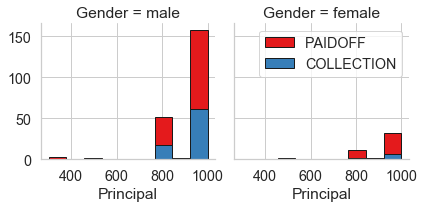

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

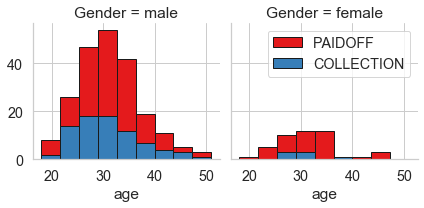

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

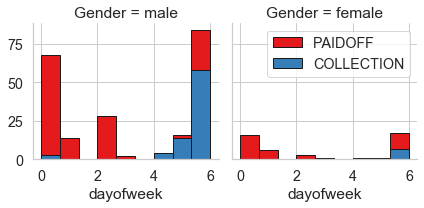

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [12]:
df['due_time'] = (df['due_date']-df['effective_date'])
df['due_time'] = (df['due_time']/np.timedelta64(1,'D')).astype('int')

## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend','due_time']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,due_time,Bechalor,High School or Below,college
0,1000,30,45,0,0,29,0,1,0
1,1000,30,33,1,0,29,1,0,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,due_time,Bechalor,High School or Below,college
0,1000,30,45,0,0,29,0,1,0
1,1000,30,33,1,0,29,1,0,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
         0.53257725, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         0.53257725,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.88417105, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.53257725, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.53257725, -0.38170062, -0.87997669,  1.14984679]])

# Classification 

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


# K Nearest Neighbor(KNN)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1, Ks):    
    #Train Model and Predict  
    model = KNeighborsClassifier(n_neighbors = n, n_jobs=-1, weights='uniform').fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)    
    std_acc[n-1] = np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

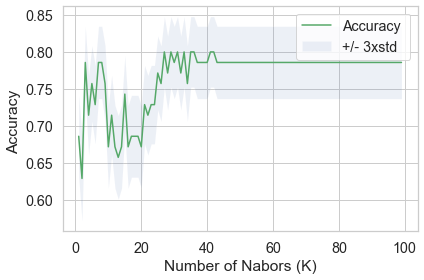

In [23]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [24]:
print( "The best accuracy is", mean_acc.max(), "when k=", mean_acc.argmax()+1) 

The best accuracy is 0.8 when k= 27


In [25]:
final_KNN = KNeighborsClassifier(n_neighbors = 50).fit(X_train,y_train)

# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1, Ks):    
    #Train Model and Predict  
    decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    y_decision_pred = decision_tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_decision_pred)    
    std_acc[n-1] = np.std(y_decision_pred == y_test)/np.sqrt(y_decision_pred.shape[0])
mean_acc

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.78571429,
       0.78571429, 0.65714286, 0.71428571, 0.72857143, 0.68571429,
       0.68571429, 0.71428571, 0.7       , 0.68571429, 0.7       ,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571429,
       0.7       , 0.7       , 0.7       , 0.68571429, 0.68571429,
       0.67142857, 0.68571429, 0.68571429, 0.67142857, 0.68571429,
       0.68571429, 0.67142857, 0.68571429, 0.68571429, 0.67142857,
       0.7       , 0.68571429, 0.68571429, 0.7       , 0.7       ,
       0.7       , 0.67142857, 0.68571429, 0.7       , 0.7       ,
       0.68571429, 0.67142857, 0.67142857, 0.7       , 0.7       ,
       0.68571429, 0.68571429, 0.7       , 0.7       , 0.68571429,
       0.67142857, 0.68571429, 0.68571429, 0.67142857, 0.68571429,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.7       ,
       0.7       , 0.67142857, 0.68571429, 0.7       , 0.67142857,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571

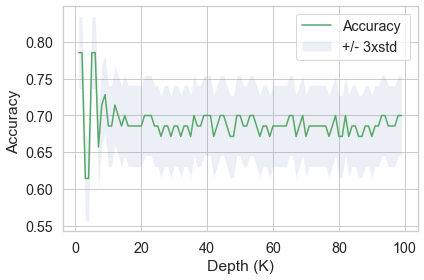

In [28]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth (K)')
plt.tight_layout()
plt.show()

In [29]:
final_decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 21).fit(X_train,y_train)

# Support Vector Machine

In [30]:
from sklearn import svm

In [31]:
final_SVM = svm.SVC(kernel='linear')
final_SVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [32]:
metrics.accuracy_score(final_SVM.predict(X_test), y_test)

0.7714285714285715

# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
Ks = 1000
lr_mean_acc = np.zeros((Ks-1))
lr_std_acc = np.zeros((Ks-1))
ConfustionMx = [];
i = 1
for n in np.arange(0.001,1,0.001 ): 
    model = LogisticRegression(C = n, solver = 'liblinear', max_iter=200).fit(X_train,y_train)
    y_pred = model.predict(X_test)
    lr_mean_acc[i-1] = metrics.accuracy_score(y_test, y_pred)    
    lr_std_acc[i-1] = np.std(y_pred == y_test)/np.sqrt(y_pred.shape[0])
    i = i +1

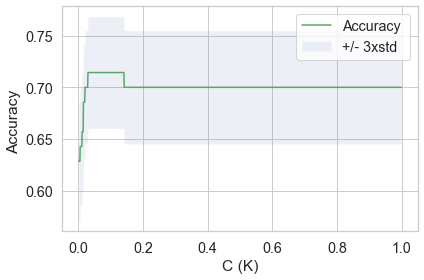

In [35]:
plt.plot(np.arange(0.001,1,0.001),lr_mean_acc,'g')
plt.fill_between(np.arange(0.001,1,0.001),lr_mean_acc - 1 * lr_std_acc,lr_mean_acc + 1 * lr_std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('C (K)')
plt.tight_layout()
plt.show()

In [36]:
print( "The best accuracy is seemingly", lr_mean_acc.max(), "when C is between 0.06 to 0.19(approx.)") 
mean_acc

The best accuracy is seemingly 0.7142857142857143 when C is between 0.06 to 0.19(approx.)


array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.78571429,
       0.78571429, 0.65714286, 0.71428571, 0.72857143, 0.68571429,
       0.68571429, 0.71428571, 0.7       , 0.68571429, 0.7       ,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571429,
       0.7       , 0.7       , 0.7       , 0.68571429, 0.68571429,
       0.67142857, 0.68571429, 0.68571429, 0.67142857, 0.68571429,
       0.68571429, 0.67142857, 0.68571429, 0.68571429, 0.67142857,
       0.7       , 0.68571429, 0.68571429, 0.7       , 0.7       ,
       0.7       , 0.67142857, 0.68571429, 0.7       , 0.7       ,
       0.68571429, 0.67142857, 0.67142857, 0.7       , 0.7       ,
       0.68571429, 0.68571429, 0.7       , 0.7       , 0.68571429,
       0.67142857, 0.68571429, 0.68571429, 0.67142857, 0.68571429,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.7       ,
       0.7       , 0.67142857, 0.68571429, 0.7       , 0.67142857,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571

In [37]:
final_lRegression = LogisticRegression(C=0.19, solver='liblinear', max_iter=200).fit(X_train,y_train)

# Model Evaluation using Test set

In [38]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [39]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [40]:
y_true = df['loan_status'].values
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['due_time'] = (test_df['due_date']-test_df['effective_date'])
test_df['due_time'] = (test_df['due_time']/np.timedelta64(1,'D')).astype('int')
Feature = df[['Principal','terms','age','Gender','weekend','due_time']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_true = Feature
X_true = preprocessing.StandardScaler().fit(X_true).transform(X_true)

## 1. KNN

In [41]:
y_pred = final_KNN.predict(X_true)

### Jaccard

In [42]:
jaccard_knn = jaccard_similarity_score(y_pred, y_true)
jaccard_knn

/Users/dylanuzan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7543352601156069

### F1- Score

In [43]:
f1score_knn = f1_score(y_pred, y_true, average='weighted')
f1score_knn

0.8570864570103521

## 2. Decision Tree

In [44]:
y_pred = final_decision_tree.predict(X_true)

### Jaccard Index

In [45]:
jaccard_decision_tree = jaccard_similarity_score(y_pred, y_true)
jaccard_decision_tree

/Users/dylanuzan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.8815028901734104

### F1 Score

In [46]:
f1score_decision_tree = f1_score(y_pred, y_true, average='weighted')
f1score_decision_tree

0.8792219222633426

## 3. SVM

In [47]:
y_pred = final_SVM.predict(X_true)

### Jaccard Index

In [48]:
jaccard_svm = jaccard_similarity_score(y_pred, y_true)
jaccard_svm

/Users/dylanuzan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7572254335260116

### F1 Score

In [49]:
f1score_svm = f1_score(y_pred, y_true, average='weighted')
f1score_svm

0.8378447841098653

## 4. Logistic Regression

In [50]:
y_pred = final_lRegression.predict(X_true)

### Jaccard

In [51]:
jaccard_logistic_regression = jaccard_similarity_score(y_pred, y_true)
jaccard_logistic_regression

/Users/dylanuzan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7514450867052023

### F1 Score

In [52]:
f1score_logistic_regression = f1_score(y_pred, y_true, average='weighted')
f1score_logistic_regression

0.7744370338984846

### Log Loss

In [53]:
np.place(y_pred, y_pred=='PAIDOFF', 1)
np.place(y_pred, y_pred=='COLLECTION', 0)
np.place(y_true, y_true=='PAIDOFF', 1)
np.place(y_true, y_true=='COLLECTION', 0)

In [54]:
y_pred = y_pred.astype(np.float)
y_true = y_true.astype(np.float)

In [55]:
logloss_logistic_regression = log_loss(y_pred, y_true)
logloss_logistic_regression

8.584842657501458

# Report
The accuracy of the built model using different evaluation metrics:

In [56]:
Jaccard = [jaccard_knn, jaccard_decision_tree, jaccard_svm, jaccard_logistic_regression]
F1_score = [f1score_knn, f1score_decision_tree, f1score_svm, f1score_logistic_regression]
LogLoss = ['NA','NA','NA',logloss_logistic_regression]

    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard, 'F1-score': F1_score, 'LogLoss': LogLoss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.754335,0.857086,NA
1,Decistion Tree,0.881503,0.879222,NA
2,SVM,0.757225,0.837845,NA
3,LogisticRegression,0.751445,0.774437,8.58484


#### We can see that Decision Tree has the better accuracy of about 88% in classifying the Paid-off and collection labels for this dataset in both Jaccard Index and F1 Score.